## Imports
### General and Data Processing Imports

In [1]:
import os
import json 
import pickle

from tqdm import tqdm
import pandas as pd

tqdm.pandas()

### Web Scraping and XML Processing Imports

In [2]:
import requests
from lxml import etree
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import metapub
from urllib.request import urlretrieve

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

2024-03-16 13:26:33 rhodes-f6eac metapub.config[257775] WARNING NCBI_API_KEY was not set.


### NLP Imports

In [3]:
import re
import spacy

2024-03-16 13:26:35.744793: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 13:26:35.744843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 13:26:35.745682: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-16 13:26:35.752161: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-16 13:26:36.637690: W tensorflow/compiler/tf2

In [4]:
RAW_DATA_PATH = '/data/01_raw_data/labels_with_references.csv'
OUTPUT_PATH = '/data/02_training_data/'

### Dataset Preparation imports

In [5]:
from preprocessing_utils import *

## Data Preparation
### Load Data
#### Convert column names to lowercase for consistency

In [6]:
data_df = pd.read_csv(RAW_DATA_PATH)
data_df.columns = [col.lower() for col in data_df.columns]
data_df = data_df.drop_duplicates()
del data_df['#'] # Remove identifier column
print(data_df.shape)
data_df.head(2)

(97, 8)


,srna,srna synonyms,type of regulation,target gene,quote,quote from,pmcid,wikidata
0,sRNA encoded by micF,"stc, b4439, ECK2208, IS113, JWR0043, micF",antisense inhibitor of,outer membrane porin F b0929,we suggest that an increased expression of the...,/Article_Viewer%2Ehtml?pmcid=PMC213846&quote=w...,213846,http://www.wikidata.org/entity/Q50418533
1,sRNA encoded by ryhB,"b4451, ECK3426, IS176, JWR0219, psrA18, ryhB, ...",antisense inhibitor of,aconitate hydratase 1 b1276,The genes regulated by RyhB include some encod...,/Article_Viewer%2Ehtml?pmcid=PMC1251601&quote=...,1251601,http://www.wikidata.org/entity/Q50419794


## Data Exploration

In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   srna                97 non-null     object
 1   srna synonyms       64 non-null     object
 2   type of regulation  97 non-null     object
 3   target gene         97 non-null     object
 4   quote               97 non-null     object
 5   quote from          97 non-null     object
 6   pmcid               97 non-null     int64 
 7   wikidata            97 non-null     object
dtypes: int64(1), object(7)
memory usage: 6.2+ KB


In [8]:
unique_counts_df = pd.DataFrame(list({col: data_df[col].nunique() for col in data_df.columns}.items()), columns=['Column', 'Unique Values']).sort_values(by='Unique Values', ascending=True)
unique_counts_df

,Column,Unique Values
2,type of regulation,3
1,srna synonyms,18
0,srna,21
7,wikidata,21
6,pmcid,30
4,quote,43
5,quote from,44
3,target gene,87


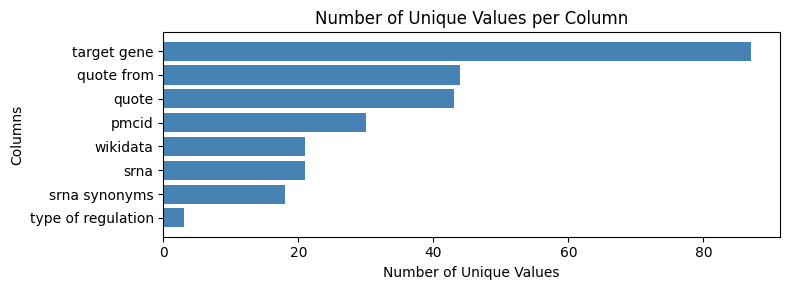

In [9]:
plt.figure(figsize=(8, 3))
plt.barh(unique_counts_df['Column'], unique_counts_df['Unique Values'], color='steelblue')
plt.xlabel('Number of Unique Values')
plt.ylabel('Columns')
plt.title('Number of Unique Values per Column')
plt.tight_layout()
plt.show()

In [10]:
print("Missing Values:")
print(data_df.isnull().sum())
print("\n")

Missing Values:
srna                   0
srna synonyms         33
type of regulation     0
target gene            0
quote                  0
quote from             0
pmcid                  0
wikidata               0
dtype: int64




# Data Preparation
## Clean column names
*Replace whitespace with underscores*

In [11]:
data_df.columns = ['_'.join(col.split()) for col in data_df.columns]
data_df.head(2)

,srna,srna_synonyms,type_of_regulation,target_gene,quote,quote_from,pmcid,wikidata
0,sRNA encoded by micF,"stc, b4439, ECK2208, IS113, JWR0043, micF",antisense inhibitor of,outer membrane porin F b0929,we suggest that an increased expression of the...,/Article_Viewer%2Ehtml?pmcid=PMC213846&quote=w...,213846,http://www.wikidata.org/entity/Q50418533
1,sRNA encoded by ryhB,"b4451, ECK3426, IS176, JWR0219, psrA18, ryhB, ...",antisense inhibitor of,aconitate hydratase 1 b1276,The genes regulated by RyhB include some encod...,/Article_Viewer%2Ehtml?pmcid=PMC1251601&quote=...,1251601,http://www.wikidata.org/entity/Q50419794


## Extract sRNA name from column sRNA

In [12]:
data_df['srna_name'] = data_df.srna.progress_apply(lambda x: x.split('sRNA encoded by ')[-1])
data_df.head(2)

100%|███████████████████████████████████████| 97/97 [00:00<00:00, 307984.47it/s]


,srna,srna_synonyms,type_of_regulation,target_gene,quote,quote_from,pmcid,wikidata,srna_name
0,sRNA encoded by micF,"stc, b4439, ECK2208, IS113, JWR0043, micF",antisense inhibitor of,outer membrane porin F b0929,we suggest that an increased expression of the...,/Article_Viewer%2Ehtml?pmcid=PMC213846&quote=w...,213846,http://www.wikidata.org/entity/Q50418533,micF
1,sRNA encoded by ryhB,"b4451, ECK3426, IS176, JWR0219, psrA18, ryhB, ...",antisense inhibitor of,aconitate hydratase 1 b1276,The genes regulated by RyhB include some encod...,/Article_Viewer%2Ehtml?pmcid=PMC1251601&quote=...,1251601,http://www.wikidata.org/entity/Q50419794,ryhB


## Transform PMCID to String format

In [13]:
data_df['pmcid'] = data_df.pmcid.progress_apply(lambda x: str(x))

100%|███████████████████████████████████████| 97/97 [00:00<00:00, 314897.44it/s]


## Replace None with empty string for column srna_synonyms

In [14]:
data_df.loc[data_df.srna_synonyms.isnull(), 'srna_synonyms'] = ''
data_df[data_df.srna_synonyms.isnull()]

,srna,srna_synonyms,type_of_regulation,target_gene,quote,quote_from,pmcid,wikidata,srna_name


## Preprocess the text data
* *remove punctuation*
* *remove extra spaces*
* *convert to lowercase*

In [15]:
data_df['text_prep'] = data_df['quote'].apply(preprocess_texts)
data_df.head(2)

,srna,srna_synonyms,type_of_regulation,target_gene,quote,quote_from,pmcid,wikidata,srna_name,text_prep
0,sRNA encoded by micF,"stc, b4439, ECK2208, IS113, JWR0043, micF",antisense inhibitor of,outer membrane porin F b0929,we suggest that an increased expression of the...,/Article_Viewer%2Ehtml?pmcid=PMC213846&quote=w...,213846,http://www.wikidata.org/entity/Q50418533,micF,we suggest that an increased expression of the...
1,sRNA encoded by ryhB,"b4451, ECK3426, IS176, JWR0219, psrA18, ryhB, ...",antisense inhibitor of,aconitate hydratase 1 b1276,The genes regulated by RyhB include some encod...,/Article_Viewer%2Ehtml?pmcid=PMC1251601&quote=...,1251601,http://www.wikidata.org/entity/Q50419794,ryhB,The genes regulated by RyhB include some encod...


## Gather additional data

### Get synonyms for target genes

In [16]:
# Vectorized operation to extract gene IDs using regex
gene_id_pattern = r'(b\d{4}|SAOUHSC_\d{4}\w)'
data_df['target_gene_id'] = data_df.target_gene.str.extract(gene_id_pattern)[0].fillna('')
data_df.head(2)

,srna,srna_synonyms,type_of_regulation,target_gene,quote,quote_from,pmcid,wikidata,srna_name,text_prep,target_gene_id
0,sRNA encoded by micF,"stc, b4439, ECK2208, IS113, JWR0043, micF",antisense inhibitor of,outer membrane porin F b0929,we suggest that an increased expression of the...,/Article_Viewer%2Ehtml?pmcid=PMC213846&quote=w...,213846,http://www.wikidata.org/entity/Q50418533,micF,we suggest that an increased expression of the...,b0929
1,sRNA encoded by ryhB,"b4451, ECK3426, IS176, JWR0219, psrA18, ryhB, ...",antisense inhibitor of,aconitate hydratase 1 b1276,The genes regulated by RyhB include some encod...,/Article_Viewer%2Ehtml?pmcid=PMC1251601&quote=...,1251601,http://www.wikidata.org/entity/Q50419794,ryhB,The genes regulated by RyhB include some encod...,b1276


In [17]:
gene_synonyms_dict = {}
for gene_id in tqdm(list(set(data_df.target_gene_id.to_list()))):
    if gene_id:
        gene_synonyms_dict[gene_id] = get_additional_gene_synonyms(gene_id)

100%|███████████████████████████████████████████| 73/73 [03:25<00:00,  2.81s/it]


In [18]:
data_df['gene_synonyms'] = data_df.target_gene_id.map(gene_synonyms_dict).fillna('')
data_df.head(3)

,srna,srna_synonyms,type_of_regulation,target_gene,quote,quote_from,pmcid,wikidata,srna_name,text_prep,target_gene_id,gene_synonyms
0,sRNA encoded by micF,"stc, b4439, ECK2208, IS113, JWR0043, micF",antisense inhibitor of,outer membrane porin F b0929,we suggest that an increased expression of the...,/Article_Viewer%2Ehtml?pmcid=PMC213846&quote=w...,213846,http://www.wikidata.org/entity/Q50418533,micF,we suggest that an increased expression of the...,b0929,"cmlB, cry, ECK0920, nfxB, tolF, ompF"
1,sRNA encoded by ryhB,"b4451, ECK3426, IS176, JWR0219, psrA18, ryhB, ...",antisense inhibitor of,aconitate hydratase 1 b1276,The genes regulated by RyhB include some encod...,/Article_Viewer%2Ehtml?pmcid=PMC1251601&quote=...,1251601,http://www.wikidata.org/entity/Q50419794,ryhB,The genes regulated by RyhB include some encod...,b1276,"acn, ECK1271, acnA"
2,sRNA encoded by ryhB,"b4451, ECK3426, IS176, JWR0219, psrA18, ryhB, ...",antisense inhibitor of,fumarase A b1612,The genes regulated by RyhB include some encod...,/Article_Viewer%2Ehtml?pmcid=PMC1251601&quote=...,1251601,http://www.wikidata.org/entity/Q50419794,ryhB,The genes regulated by RyhB include some encod...,b1612,"ECK1607, fumA"


In [19]:
data_df.shape

(97, 12)

## Quality check annotations

In [20]:
rows_to_add = []
# Get a list of all quotes
quotes = data_df.text_prep.unique()
for quote in tqdm(quotes):
    matched_rows = data_df[data_df.text_prep == quote]
    for _, row in matched_rows.iterrows():
        srna_name = find_name_in_quote(quote, row['srna_name'], row['srna_synonyms'].split(', '))
        gene_name = find_name_in_quote(quote, row['target_gene'], row['gene_synonyms'].split(', '), row['target_gene_id'])
        row_dict = row.to_dict()
        row_dict['srna_name_mentioned'] = srna_name 
        row_dict['gene_name_mentioned'] = gene_name
        rows_to_add.append(row_dict)

# Create the DataFrame from the list of dictionaries
temp_df = pd.DataFrame(rows_to_add)

100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 1481.89it/s]


In [21]:
print(temp_df.shape)
temp_df.head(2)

(97, 14)


,srna,srna_synonyms,type_of_regulation,target_gene,quote,quote_from,pmcid,wikidata,srna_name,text_prep,target_gene_id,gene_synonyms,srna_name_mentioned,gene_name_mentioned
0,sRNA encoded by micF,"stc, b4439, ECK2208, IS113, JWR0043, micF",antisense inhibitor of,outer membrane porin F b0929,we suggest that an increased expression of the...,/Article_Viewer%2Ehtml?pmcid=PMC213846&quote=w...,213846,http://www.wikidata.org/entity/Q50418533,micF,we suggest that an increased expression of the...,b0929,"cmlB, cry, ECK0920, nfxB, tolF, ompF",micF,ompF
1,sRNA encoded by ryhB,"b4451, ECK3426, IS176, JWR0219, psrA18, ryhB, ...",antisense inhibitor of,aconitate hydratase 1 b1276,The genes regulated by RyhB include some encod...,/Article_Viewer%2Ehtml?pmcid=PMC1251601&quote=...,1251601,http://www.wikidata.org/entity/Q50419794,ryhB,The genes regulated by RyhB include some encod...,b1276,"acn, ECK1271, acnA",RyhB,"[acnA, acn]"


## Manual Quality Control on Dataset
### Manually check labels:

In [22]:
i = 0

print(quotes[i] + '\n')
for _, row in temp_df[temp_df.text_prep==quotes[i]].iterrows():
    print(f'PMCID: {row["pmcid"]}')
    print(f'sRNA: {row["srna_name"]}; mentioned: {row["srna_name_mentioned"]}')
    print(f'Regulation: {row["type_of_regulation"]}')
    print(f'Gene: {row["target_gene"]} /ID: {row["target_gene_id"]} /Symbol: {row["gene_synonyms"]}; mentioned: {row["gene_name_mentioned"]}')
    print()

we suggest that an increased expression of the micF gene in a tolC mutant results in the reduced expression of ompF

PMCID: 213846
sRNA: micF; mentioned: micF
Regulation: antisense inhibitor of
Gene: outer membrane porin F b0929 /ID: b0929 /Symbol: cmlB, cry, ECK0920, nfxB, tolF, ompF; mentioned: ompF



In [23]:
print(temp_df[temp_df.srna_name_mentioned=="unknown"].shape)
temp_df[temp_df.gene_name_mentioned=="unknown"].shape

(8, 14)


(38, 14)

### Manually fill in sRNA and gene names that were not found by the function (if possible)

In [24]:
# For the statement of Spot 42 sRNA, encoded by spf regulating galK (from PMCID: 186370): 
rows_to_add = append_gene_data(df=temp_df, quote=temp_df[temp_df.pmcid=="186370"].text_prep.iloc[0], genes=["gal"],  rows_to_add=rows_to_add, srna_names=['Spot 42'])


### Add manual adjustments to the labels
#### Add additional gene / sRNAs that were mentioned in the quote but are not listed in the dataset

In [25]:
# For the statement of RyhB regulating sdhCDAB (from PMCID: 1251601): 
rows_to_add = append_gene_data(df=temp_df, quote=temp_df[temp_df.pmcid=="1251601"].text_prep.iloc[0], genes=["sdhCDAB", "isc", "nuo", "fdo", "hyb", "frd"],  rows_to_add=rows_to_add)

# For the statement of DsrA regulating ilvIH (from PMCID: 22852): 
rows_to_add = append_gene_data(df=temp_df, quote=temp_df[temp_df.pmcid=="22852"].text_prep.iloc[0], genes=["ilvIH"],  rows_to_add=rows_to_add)

# For the statement of GcvB regulating gltI livJ livK ytfT aroP and argT (from PMCID: 1464411): ytfT and aroP are missing:
rows_to_add = append_gene_data(df=temp_df, quote=temp_df[temp_df.pmcid=="1464411"].text_prep.iloc[0], genes=["ytfT", "aroP"],  rows_to_add=rows_to_add)

# For the statement of FnrS regulating mqo sodA yebZ and yobA (from PMCID: 3072601): mqo and yebZ are missing
rows_to_add = append_gene_data(df=temp_df, quote=temp_df[temp_df.pmcid=="3072601"].text_prep.iloc[0], genes=["mqo", "yebZ"],  rows_to_add=rows_to_add)

In [26]:
# For the statement of both OmrA and OmrB regulating cirA and ompT (from PMCID: 2588501): the statements were only listed for OmrA -> ompT and omrB -> cirA
row = temp_df[(temp_df.pmcid=="2588501")&(temp_df.text_prep.str.startswith('Therefore'))].iloc[-1]
row_dict = row.to_dict()
row_dict['srna_name_mentioned'] = "OmrA"
row_dict['gene_name_mentioned'] = "cirA"
rows_to_add.append(row_dict)

row = temp_df[(temp_df.pmcid=="2588501")&(temp_df.text_prep.str.startswith('Therefore'))].iloc[-2]
row_dict = row.to_dict()
row_dict['srna_name_mentioned'] = "OmrB"
row_dict['gene_name_mentioned'] = "ompT"
rows_to_add.append(row_dict)

In [27]:
# For the statement of cyaR regulating ompX, yqaE, nadE, luxS and yobF (from PMCID: 5861431): yobF is missing
rows_to_add = append_gene_data(temp_df, temp_df[temp_df.pmcid=="5861431"].text_prep.iloc[0], ["yobF"], rows_to_add)

# For the statement of rydC regulating csgD and yejABEF (from PMCID: 3985669): yejABEF is missing
rows_to_add = append_gene_data(temp_df, temp_df[temp_df.pmcid=="3985669"].text_prep.iloc[0], ["yejABEF"], rows_to_add)

# For the statement of SprY regulating RNAIII, rpmg1 and SAOUHSC_1342a  (from PMCID: 8501977): rpmG1 is missing
rows_to_add = append_gene_data(temp_df, temp_df[temp_df.pmcid=="8501977"].text_prep.iloc[0], ["rpmG1"], rows_to_add)

In [28]:
# For the statement of OmrA OmrB McaS GcvB and RprA regulating csgDEFG (from PMCID: 4243835): McaS is missing
row = temp_df[temp_df.pmcid=="4243835"].iloc[-1]
gene = "csgDEFG"
for srna in ["OmrA", "OmrB", "McaS", "GcvB", "RprA"]:
    row_dict = row.to_dict()
    row_dict['srna_name_mentioned'] = srna
    row_dict['gene_name_mentioned'] = gene
    rows_to_add.append(row_dict)

In [29]:
# # For the statement of dsrA regulating argR, ilvIH and rbsD (from PMCID: 22852): rbsD is missing
rows_to_add = append_gene_data(temp_df, temp_df[temp_df.pmcid=="22852"].text_prep.iloc[0], ["rbsD"], rows_to_add)

# For the statement of rhyB regulating nuoA, fdoG and sodA (from PMCID: 3311362): nuoA and sodA are missing
rows_to_add = append_gene_data(temp_df, temp_df[(temp_df.pmcid=="3311362")&(temp_df.text_prep.str.startswith("Analysis of the levels of"))].text_prep.iloc[0], ["nuoA", "sodA", "sdhC"], rows_to_add)

In [30]:
data_df[(data_df.pmcid=="2588501")&(data_df.text_prep.str.startswith('Altogether'))].text_prep.iloc[0]

'Altogether these results suggest that OmrA/B could base pair with the leader of yjcH or ompR and thereby regulate the expression of the corresponding operons'

In [31]:
# For the statement of OmrA/B regulating yjcH, ompR (from PMCID: 2588501): OmrA/B is only listed as OmrA
row = temp_df[(temp_df.pmcid=="2588501")&(temp_df.text_prep.str.startswith("Altogether these results suggest"))].iloc[-1]
row_dict = row.to_dict()
row_dict['gene_name_mentioned'] = "ompR"
rows_to_add.append(row_dict)
    
for gene in ["yjcH", "ompR"]:
    row_dict = row.to_dict()
    row_dict['srna_name_mentioned'] = 'omrA/B'
    row_dict['gene_name_mentioned'] = gene
    rows_to_add.append(row_dict)

In [32]:
# For the statement of OmrA and OmrB regulating fecA and fepA (from PMCID: 2588501): nuoA and sodA are missing
row = temp_df[(temp_df.pmcid=="2588501")&(temp_df.text_prep.str.startswith("We have previously shown that OmrA an"))].iloc[0]
for gene in ["fecA", "fepA"]:
    row_dict = row.to_dict()
    row_dict['srna_name_mentioned'] = 'OmrB'
    row_dict['gene_name_mentioned'] = gene
    rows_to_add.append(row_dict)

In [33]:
# For the statement of GcvA, GcvB and Hfq regulating hdeB and hdeA (from PMCID: 3658693): GvcA and Hfq are missing completely while gcvB -> hdeA is also missing
# GcvA, SRNA GcvB, and Hfq
row = temp_df[temp_df.pmcid=="3658693"].iloc[-1]
row_dict = row.to_dict()
row_dict['gene_name_mentioned'] = "hdeA"
rows_to_add.append(row_dict)

for srna in ["GcvA", "Hfq"]:    
    for gene in ["λhdeB", "hdeA"]:
        row_dict = row.to_dict()
        row_dict['srna_name_mentioned'] = srna
        row_dict['gene_name_mentioned'] = gene
        rows_to_add.append(row_dict)

In [34]:
# For the statement of DsrA RprA and ArcZ regulating rpoS (from PMCID: 3937726): DsrA is missing
rows_to_add = append_gene_data(temp_df, temp_df[temp_df.pmcid=="3937726"].text_prep.iloc[-1], ["rpoS"], rows_to_add, ["DsrA"])


In [35]:
# For the statement of sibS and ohsC repressing ibs and shoB (from PMCID: 2597788): sibS and ibs are missing
row = temp_df[temp_df.pmcid=="2597788"].iloc[-1]
for gene in ["ibs", "shoB"]:
    row_dict = row.to_dict()
    row_dict['srna_name_mentioned'] = 'SibS'
    row_dict['gene_name_mentioned'] = gene
    rows_to_add.append(row_dict)

row_dict = row.to_dict()
row_dict['gene_name_mentioned'] = "ibs"

In [36]:
# For the statement of OmpR activating omrA and omrB (from PMCID: 5175337) sRNA and target gene were swapped and omrA/B is only listed as omrA. 
# (The line (index 54 in data_df) with the incorrect annotation will be removed at a later stage)
row = temp_df[temp_df.pmcid=="5175337"].iloc[-1]
row_dict = row.to_dict()
row_dict['srna_name_mentioned'] = "OmpR"
row_dict['gene_name_mentioned'] = 'ompA/B'
# Remove wrong annotation:
rows_to_add.remove(next(item for item in rows_to_add if item["pmcid"] == "5175337" and item["gene_name_mentioned"] == "OmpR"))
rows_to_add.append(row_dict)

In [37]:
# For the statement of SarA repressing  sspA sspB, sspC and aur (from PMCID: 8510525) sspA sspB, sspC do not match the gene name extracted on a semantic level. aur is missing  
rows_to_add = append_gene_data(temp_df, temp_df[(temp_df.pmcid=="8510525")&(temp_df.text_prep.str.startswith("The data confirm that among"))].text_prep.iloc[0], ["sspA", "sspB", "sspC", "aur"], rows_to_add)

# For the statement of SarA repressing  nuc (from PMCID: 8510525) nuc does not match the gene name extracted on a semantic level.
rows_to_add = append_gene_data(temp_df, temp_df[(temp_df.pmcid=="8510525")&(temp_df.text_prep.str.startswith("The expression of the thermonuclease"))].text_prep.iloc[0], ["nuc"], rows_to_add)

In [38]:
temp_df.shape

(97, 14)

## Consolidate manipulated data to DataFrame

In [39]:
# Create the DataFrame from the list of dictionaries
temp_df = pd.DataFrame(rows_to_add)

*Update quotes (index 79 and 80) to new string ranges to include the entities that were extracted:*

### Filter out rows with unknown or NoneType sRNA and Target Gene names

In [40]:
temp_df = temp_df[(temp_df.srna_name_mentioned!="unknown")&(~temp_df.srna_name_mentioned.isnull())]
temp_df = temp_df[(temp_df.gene_name_mentioned!="unknown")&(~temp_df.gene_name_mentioned.isnull())]

#### Assign modified temp_df back to data_df

In [41]:
data_df = temp_df
print(data_df.shape)
data_df.head(2)

(100, 14)


,srna,srna_synonyms,type_of_regulation,target_gene,quote,quote_from,pmcid,wikidata,srna_name,text_prep,target_gene_id,gene_synonyms,srna_name_mentioned,gene_name_mentioned
0,sRNA encoded by micF,"stc, b4439, ECK2208, IS113, JWR0043, micF",antisense inhibitor of,outer membrane porin F b0929,we suggest that an increased expression of the...,/Article_Viewer%2Ehtml?pmcid=PMC213846&quote=w...,213846,http://www.wikidata.org/entity/Q50418533,micF,we suggest that an increased expression of the...,b0929,"cmlB, cry, ECK0920, nfxB, tolF, ompF",micF,ompF
1,sRNA encoded by ryhB,"b4451, ECK3426, IS176, JWR0219, psrA18, ryhB, ...",antisense inhibitor of,aconitate hydratase 1 b1276,The genes regulated by RyhB include some encod...,/Article_Viewer%2Ehtml?pmcid=PMC1251601&quote=...,1251601,http://www.wikidata.org/entity/Q50419794,ryhB,The genes regulated by RyhB include some encod...,b1276,"acn, ECK1271, acnA",RyhB,"[acnA, acn]"


In [42]:
data_df['srna_name_mentioned'] = data_df['srna_name_mentioned'].apply(lambda x: ', '.join(x) if type(x)==list else x)
data_df['gene_name_mentioned'] = data_df['gene_name_mentioned'].apply(lambda x: ', '.join(x) if type(x)==list else x)

In [43]:
data_df = data_df.drop_duplicates()
data_df.shape

(99, 14)

## Correct Regulation Type Labels
### "Activator of"

*Some sentences clearly state an activation process but are not labeled with the regulation type "activator of"*
>This is corrected by checking for sentences that contain "activat" (activation, activate, etc.) but not "regul" (regulation, regulated, etc.)

In [44]:
data_df.loc[(data_df.text_prep.str.contains('activat'))&(~data_df.text_prep.str.contains('regul'))&(data_df.type_of_regulation!='activator of'), 'type_of_regulation'] = 'activator of'

In [108]:
data_df.type_of_regulation.value_counts()

type_of_regulation
antisense inhibitor of           68
regulates (molecular biology)    24
activator of                      7
Name: count, dtype: int64

## Split the dataset into train and test sets
*Split the dataset into training and test sets using the `train_test_split` function from scikit-learn.*

In [96]:
train_texts, test_texts = train_test_split(data_df[['text_prep', 'type_of_regulation']].drop_duplicates(), test_size=0.3, random_state=42, stratify=data_df[['text_prep', 'type_of_regulation']].drop_duplicates()['type_of_regulation'])

In [110]:
train_df = data_df[data_df.text_prep.isin(train_texts.text_prep)]
test_df = data_df[data_df.text_prep.isin(test_texts.text_prep)]

print(train_df.shape)
test_df.shape

(72, 14)


(27, 14)

In [111]:
train_df.shape[0]/(train_df.shape[0]+test_df.shape[0])

0.7272727272727273

In [112]:
train_df.type_of_regulation.value_counts()

type_of_regulation
antisense inhibitor of           51
regulates (molecular biology)    15
activator of                      6
Name: count, dtype: int64

In [113]:
test_df.type_of_regulation.value_counts()

type_of_regulation
antisense inhibitor of           17
regulates (molecular biology)     9
activator of                      1
Name: count, dtype: int64

## Create NER Datasets in form of spacy Docs
*Spacy Docs contain the text enriched by annotations; in this case the entities*

In [101]:
# Load the spaCy model
nlp = spacy.load("en_core_sci_sm")

/home/bernards/sRNA_extraction/srna_venv/lib/python3.10/site-packages/spacy/language.py:2141: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [103]:
train_dataset = create_dataset([combine_text_and_entities(quote, 
                                                       train_df[train_df.text_prep==quote].srna_name_mentioned.unique(), 
                                                       train_df[train_df.text_prep==quote].gene_name_mentioned.unique()) 
                             for quote in train_df.text_prep.unique()], nlp)
test_dataset = create_dataset([combine_text_and_entities(quote, 
                                                       test_df[test_df.text_prep==quote].srna_name_mentioned.unique(), 
                                                       test_df[test_df.text_prep==quote].gene_name_mentioned.unique()) 
                             for quote in test_df.text_prep.unique()], nlp)

In [104]:
entity_types = ["SRNA", "TARGETGENE"]
# 'O' label assigned to 0
label_to_id = {"O": 0}

# Add labels for each entity type
for entity_type in entity_types:
    label_to_id[f"B-{entity_type}"] = len(label_to_id)
    label_to_id[f"I-{entity_type}"] = len(label_to_id)
    
# Convert it to id_to_label
id_to_label = {id: label for label, id in label_to_id.items()}

print(label_to_id)
print(id_to_label)

{'O': 0, 'B-SRNA': 1, 'I-SRNA': 2, 'B-TARGETGENE': 3, 'I-TARGETGENE': 4}
{0: 'O', 1: 'B-SRNA', 2: 'I-SRNA', 3: 'B-TARGETGENE', 4: 'I-TARGETGENE'}


In [105]:
# Writing label_to_id to a JSON file
with open(os.path.join(OUTPUT_PATH, 'label_to_id.json'), 'w') as file:
    json.dump(label_to_id, file)

# Writing id_to_label to a JSON file
with open(os.path.join(OUTPUT_PATH, 'id_to_label.json'), 'w') as file:
    json.dump(id_to_label, file)

## Write Output to Disk

### Save NER Datasets

In [106]:
# Save the datasets
pickle.dump(train_dataset, open(os.path.join(OUTPUT_PATH, 'train_NER.pickle'), "wb"))
pickle.dump(test_dataset, open(os.path.join(OUTPUT_PATH, 'test_NER.pickle'), "wb"))

### Save DataFrames

In [107]:
# 
train_df.to_parquet(os.path.join(OUTPUT_PATH, 'train_df.pq'), engine='pyarrow', index=False)
test_df.to_parquet(os.path.join(OUTPUT_PATH, 'test_df.pq'), engine='pyarrow', index=False)